# Example 7-1. Code to generate k-means examples

(-0.06962620218895321,
 1.0708798958416583,
 -0.08328529365353732,
 1.0817489521681318)

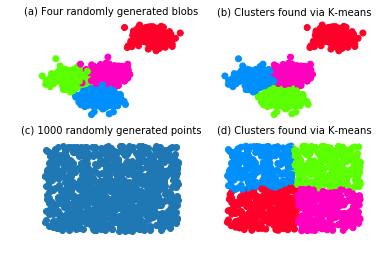

In [14]:
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_data =  1000  
seed =  1  
n_clusters =  4 
 
#相同方差 不同均值
blobs, blob_labels = make_blobs( n_samples = n_data, n_features = 2 , centers = n_clusters, random_state = seed)
clusters_blob = KMeans( n_clusters = n_clusters, random_state = seed).fit_predict(blobs)
#隨機產生 
uniform = np.random.rand(n_data, 2 )
clusters_uniform = KMeans( n_clusters = n_clusters, random_state = seed).fit_predict(uniform)
 

figure = plt.figure()
plt.subplot(221)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, cmap='gist_rainbow')
plt.title("(a) Four randomly generated blobs", fontsize=10)
plt.axis('off')
plt.subplot(222)
plt.scatter(blobs[:, 0], blobs[:, 1], c=clusters_blob, cmap='gist_rainbow')
plt.title("(b) Clusters found via K-means", fontsize=10)
plt.axis('off')
plt.subplot(223)
plt.scatter(uniform[:, 0], uniform[:, 1])
plt.title("(c) 1000 randomly generated points", fontsize=10) 
plt.axis('off')
plt.subplot(224)
plt.scatter(uniform[:, 0], uniform[:, 1], c=clusters_uniform, cmap='gist_rainbow') 
plt.title("(d) Clusters found via K-means", fontsize=10)
plt.axis('off')


# k-means featurizer

In [4]:
import numpy as np
from sklearn.cluster import KMeans
class KMeansFeaturizer:

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state 

    def fit(self, X, y=None):
        # No target variable, just do plain k-means
        if y is None:
            km_model = KMeans(n_clusters=self.k,n_init=20,random_state=self.random_state)
            km_model.fit(X)
            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self
        # There is target information. Apply appropriate scaling and include
        # it in the input data to k-means.
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))
        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k,n_init=20,random_state=self.random_state)
        km_model_pretrain.fit(data_with_target) 
        
        km_model = KMeans(n_clusters=self.k,init=km_model_pretrain.cluster_centers_[:,:2],n_init=1,max_iter=1)
        km_model.fit(X) 
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self 
    
    def transform(self, X, y=None):

        clusters = self.km_model.predict(X)
        return clusters[:,np.newaxis] 
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)



#  Classification with k-means cluster features

In [5]:
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from scipy.spatial import Voronoi, voronoi_plot_2d 
from sklearn.datasets import make_moons
import sklearn 

training_data, training_labels = make_moons(n_samples=2000, noise=0.2)  

kmf_hint= KMeansFeaturizer(k=100, target_scale=10).fit(training_data,  training_labels)  
kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0).fit(training_data,  training_labels)

test_data, test_labels = make_moons(n_samples=2000, noise=0.3) 
 
training_cluster_features = kmf_hint.transform(training_data) 
test_cluster_features = kmf_hint.transform(test_data) 

training_with_cluster = np.concatenate((training_data, training_cluster_features),axis=1)
test_with_cluster = np.concatenate((test_data, test_cluster_features),axis=1)

lr_cluster = LogisticRegression(random_state=seed).fit(training_with_cluster, training_labels) 
classifier_names = ['LR','kNN','RBF SVM','Random Forest','Boosted Trees'] 
classifiers = [LogisticRegression(random_state=seed),
               KNeighborsClassifier(5),
               SVC(gamma=2, C=1,probability=True),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=5)] 
for model in classifiers:     
    model.fit(training_data, training_labels) 

def test_roc(model, data, labels): 
    if hasattr(model, "decision_function"):         
        predictions = model.decision_function(data)     
    else:         
        predictions = model.predict_proba(data)[:,1]     
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)     
    return fpr, tpr 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


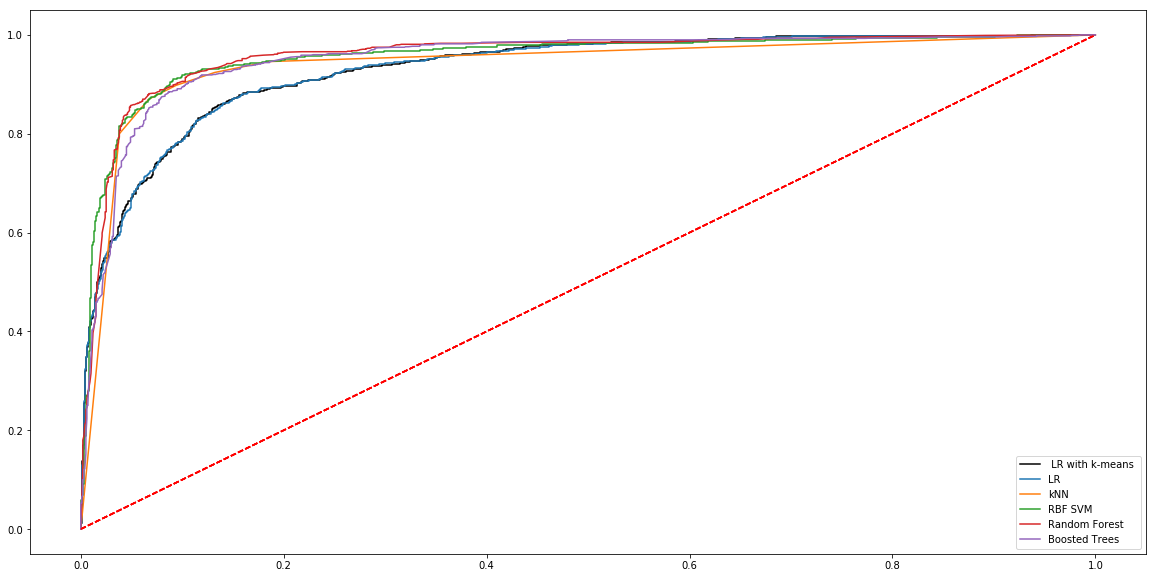

In [9]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels) 
plt.plot(fpr_cluster, tpr_cluster , 'k-',label = ' LR with k-means ' )
for i, model in  enumerate (classifiers):     
    fpr, tpr = test_roc(model, test_data, test_labels) 
    plt.plot(fpr, tpr, label = classifier_names[i])      
    plt.plot([ 0 , 1 ], [ 0 , 1 ], 'r--')
    plt.legend() 

# Example 7-2. k-means on the Swiss roll

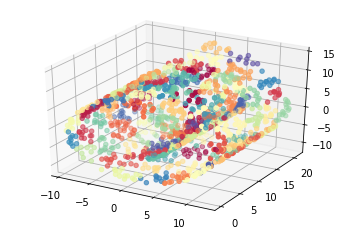

In [2]:
from mpl_toolkits.mplot3d import Axes3D 
from sklearn import manifold, datasets
 
X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)
# Approximate the data with 100 k-means clusters
clusters_swiss_roll = KMeans(n_clusters=100, random_state=1).fit_predict(X)
# Plot the dataset with k-means cluster IDs as the color
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters_swiss_roll, cmap='Spectral')


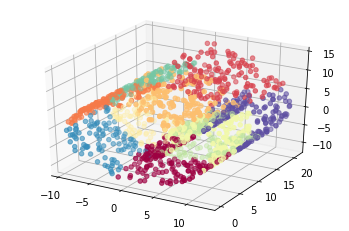

In [3]:
from mpl_toolkits.mplot3d import Axes3D 
from sklearn import manifold, datasets
 
X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)
# Approximate the data with 100 k-means clusters
clusters_swiss_roll = KMeans(n_clusters=10, random_state=1).fit_predict(X)
# Plot the dataset with k-means cluster IDs as the color
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters_swiss_roll, cmap='Spectral')


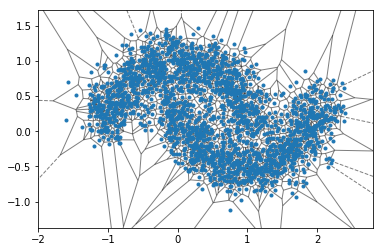

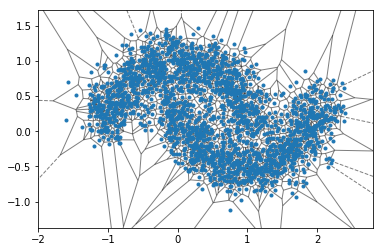

In [7]:
kmf_hint_cluster_centers = kmf_hint.transform(training_data) 
training_with_cluster = np.concatenate((training_data, kmf_hint_cluster_centers),axis=1)

kmf_hint_cluster_centers_n = kmf_no_hint.transform(training_data) 
training_with_cluster_n = np.concatenate((training_data, kmf_hint_cluster_centers_n),axis=1)

ax.scatter(training_data[:, 0], training_data[:, 1], c=training_labels, cmap='Set1', alpha=0.2)
vor = Voronoi(training_with_cluster[:,:2])
# voronoi_plot_2d(vor, show_vertices=False, alpha=0.5)
voronoi_plot_2d(vor, show_vertices=False, line_alpha=0.5)
ax.scatter(training_data[:, 0], training_data[:, 1], c=training_labels, cmap='Set1', alpha=0.2)
vor_n = Voronoi(training_with_cluster_n[:,:2])
fig = voronoi_plot_2d(vor_n, show_vertices=False,line_alpha=0.5)


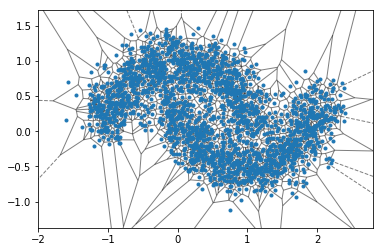

In [8]:
ax.scatter(training_data[:, 0], training_data[:, 1], c=training_labels, cmap='Set1', alpha=0.2)
vor_n = Voronoi(training_with_cluster_n[:,:2])
fig = voronoi_plot_2d(vor_n, show_vertices=False,line_alpha=0.5)


In [ ]:
training_cluster_features_n= kmf_no_hint.transform(test_data) 
test_cluster_features_n= kmf_no_hint.transform(test_data) 
training_with_cluster_n = np.concatenate((training_data, training_cluster_features_n),axis=1)
test_with_cluster_n = np.concatenate((test_data, test_cluster_features_n),axis=1)
